## Просмотр данных

In [1]:
import numpy as np
import os
from pathlib import Path
from PIL import Image
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader, sampler, random_split
import torchvision.transforms as tt

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
%matplotlib inline
#plots in the line below the code, inside the notebook

Набор данных содержит папку со всеми данными и следующую структуру каталогов:

![Структура файлов в датасете](img.png)

In [2]:
#файл 95-Cloud Scene IDs, тип excel
ids95 = pd.read_excel('data/95-cloud_training_only_additional_to38-cloud/95-Cloud_SceneIDs_lat_lon.xlsx')
ids95.head()

,SceneID,latitude,longitude,"Latitude,longitude",Unnamed: 4,Unnamed: 5,g
0,LC08_L1TP_002053_20160520_20170324_01_T1,10.12258,-63.96202,"10.12258,-63.96202",NaN,NaN,NaN
1,LC08_L1TP_002054_20160520_20170324_01_T1,8.67720,-64.27505,"8.6772,-64.27505",NaN,NaN,NaN
2,LC08_L1TP_006248_20160820_20170322_01_T1,81.33221,-20.56977,"81.33221,-20.56977",NaN,NaN,NaN
3,LC08_L1TP_007054_20170729_20170811_01_T1,8.67860,-72.01910,"8.6786,-72.0191",NaN,NaN,NaN
4,LC08_L1TP_011002_20160620_20170323_01_T1,79.99852,-19.63154,"79.99852,-19.63154",NaN,NaN,NaN


По следующим ссылкам показаны карты, включающие систему координат, используемую спутником Landsat 8, а также широты и долготы.

[World Reference System 2- Daytime, descending](https://prd-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/styles/full_width/public/thumbnails/image/wrs2.gif)

[World Reference System 2- Nightime, ascending](https://www.usgs.gov/media/images/world-reference-system-2-wrs-2-nightascending)

**LXSS_LLLL_PPPRRR_YYYYMMDD_yyyymmdd_CC_TX**
* L = Landsat (constant)

* X = Sensor (C = OLI / TIRS, O = OLI-only, T= TIRS-only, E = ETM+, T = TM, M= MSS)

* SS = 08 : Landsat 8

* LLLL = L1TP : Processing level, L1TP это точность и коррекция рельефа (L1TP, L1GT, L1GS)

* PPP = WRS path

* RRR = WRS row

* YYYYMMDD = Acquisition Year (YYYY) / Month (MM) / Day (DD)

* yyyymmdd = Processing Year (yyyy) / Month (mm) / Day (dd)

* CC = 01 : Collection number
* TX= RT for Real-Time, T1 for Tier 1 (highest quality), and T2 for Tier 2


Каждая папка содержит изображения в формате * * TIF**.
1. **Entire scene ground truth**: Это маски для целых сцен, то есть без кадрирования, которые предоставляет спутник Landsat. Это изображения размером 8000x8000 пикселей, цвет 0 или 255 в масштабе RGB (черный или белый).

In dir 75 images.


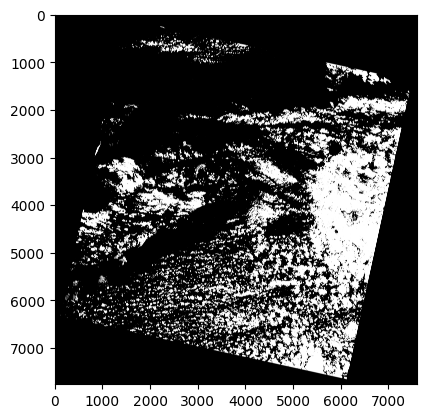

In [3]:
print('In dir ' + str(len(os.listdir('data/95-cloud_training_only_additional_to38-cloud/Entire_Scene_gts'))) + ' images.')
es_img = Image.open('data/95-cloud_training_only_additional_to38-cloud/Entire_Scene_gts/edited_corrected_gts_LC08_L1TP_002053_20160520_20170324_01_T1.TIF')
plt.imshow(es_img)

2. **Train blue**: Это неперекрывающиеся фрагменты целых сцен в синей видимой полосе LANDSAT8 размером 384x384 пикселя.

In dir 26301 images.


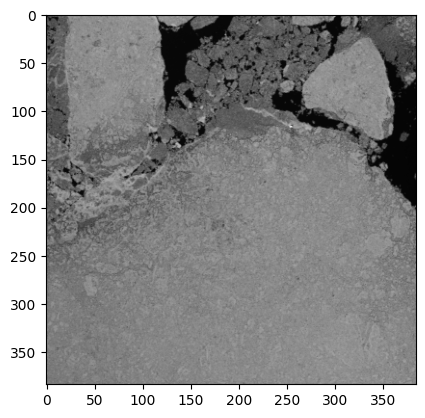

In [7]:
print('In dir ' + str(len(os.listdir('data/95-cloud_training_only_additional_to38-cloud/train_blue_additional_to38cloud'))) + ' images.')
blue_img = Image.open('data/95-cloud_training_only_additional_to38-cloud/train_blue_additional_to38cloud/blue_patch_100_5_by_12_LC08_L1TP_006248_20160820_20170322_01_T1.TIF')
plt.imshow(blue_img, cmap='gray')

3. **Train Green**:  Это неперекрывающиеся фрагменты целых сцен в зеленой видимой полосе Landsat размером 384x384 пикселя.

In dir 26301 images.


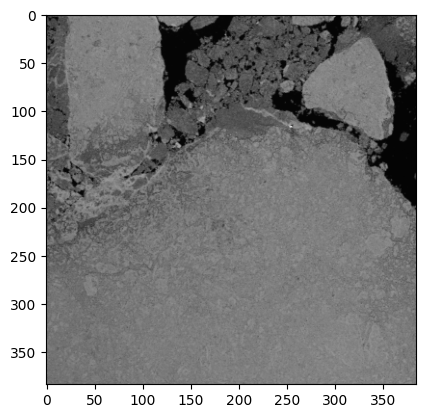

In [8]:
print('In dir ' + str(len(os.listdir('data/95-cloud_training_only_additional_to38-cloud/train_green_additional_to38cloud'))) + ' images.')
green_img = Image.open('data/95-cloud_training_only_additional_to38-cloud/train_green_additional_to38cloud/green_patch_100_5_by_12_LC08_L1TP_006248_20160820_20170322_01_T1.TIF')
plt.imshow(green_img, 'gray')

4. **Train red**: Это неперекрывающиеся фрагменты целых сцен в видимой красной полосе Landsat размером 384x384 пикселя.

In dir 26301 images.


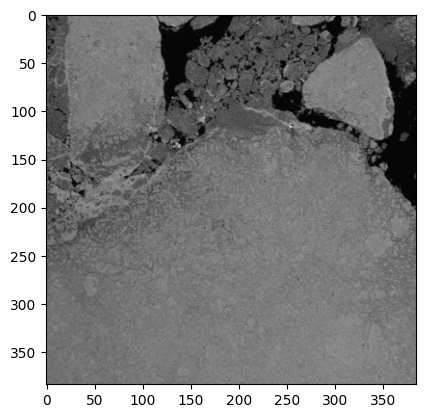

In [6]:
print('In dir ' + str(len(os.listdir('data/95-cloud_training_only_additional_to38-cloud/train_red_additional_to38cloud'))) + ' images.')
red_img = Image.open('data/95-cloud_training_only_additional_to38-cloud/train_red_additional_to38cloud/red_patch_100_5_by_12_LC08_L1TP_006248_20160820_20170322_01_T1.TIF')
plt.imshow(red_img, cmap='gray')

5. **Train nir** (Ближний инфракрасный диапазон):  Это неперекрывающиеся фрагменты целых сцен в диапазоне ближнего инфракрасного диапазона Landsat размером 384x384 пикселя.

In dir 26301 images.


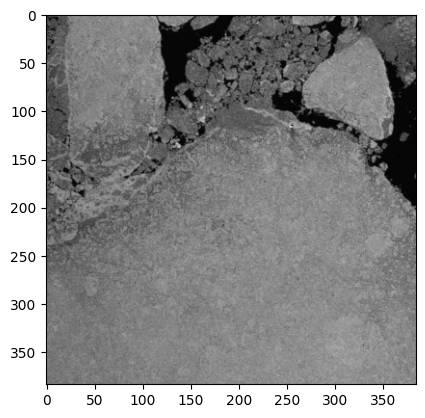

In [7]:
print('In dir ' + str(len(os.listdir('data/95-cloud_training_only_additional_to38-cloud/train_nir_additional_to38cloud'))) + ' images.')
nir_img = Image.open('data/95-cloud_training_only_additional_to38-cloud/train_nir_additional_to38cloud/nir_patch_100_5_by_12_LC08_L1TP_006248_20160820_20170322_01_T1.TIF')
plt.imshow(nir_img, 'gray')

In [8]:
#Идентификация сцены, к которой относится этот фрагмент
ids95.SceneID == 'LC08_L1TP_006248_20160820_20170322_01_T1'
print('Latitud: ' + str(ids95.latitude[2]) + '; Longitud: ' + str(ids95.longitude[2]))

Latitud: 81.33221; Longitud: -20.56977


6. **train gt**: Это неперекрывающиеся вырезы размером 384x384 пикселя из масок для целых сцен. Всего их 26301.

Size: (384, 384)
Max = 255 ; Min = 0
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


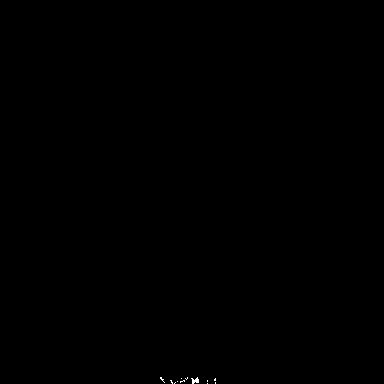

In [25]:
gt_img = Image.open('data/95-cloud_training_only_additional_to38-cloud/train_gt_additional_to38cloud/gt_patch_100_5_by_12_LC08_L1TP_047011_20160920_20170221_01_T1.TIF')
gt_array = np.array(gt_img)
print('Size: ' + str(gt_array.shape))
print('Max = ' + str(gt_array.max()) + ' ; ' + 'Min = ' + str(gt_array.min()))
print(gt_array)
gt_img

Изображение с тремя полосами, объединенными для формирования изображения RGB, и их соответствующей маской, они не нормализованы.

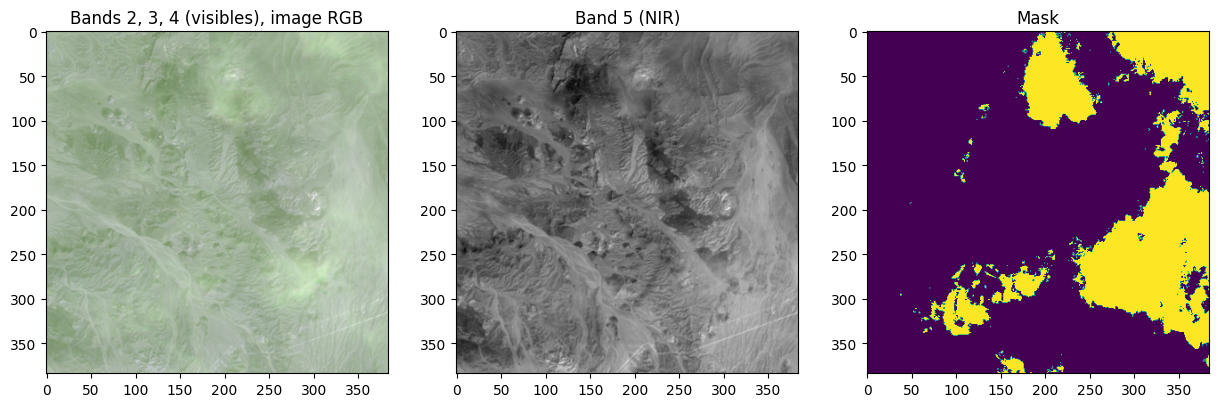

In [28]:
img_str = '_patch_25_2_by_5_LC08_L1TP_039036_20160320_20170224_01_T1.TIF'

r = np.array(Image.open('data/95-cloud_training_only_additional_to38-cloud/train_red_additional_to38cloud/red' + img_str))
r = r/r.max()
g = np.array(Image.open('data/95-cloud_training_only_additional_to38-cloud/train_green_additional_to38cloud/green' + img_str))
g = g/g.max()
b = np.array(Image.open('data/95-cloud_training_only_additional_to38-cloud/train_blue_additional_to38cloud/blue' + img_str))
b = b/b.max()
rgb = np.zeros([384,384,3])
rgb[:,:,0] = g
rgb[:,:,1] = b
rgb[:,:,2] = r

plt.figure(figsize=(15,15))

plt.subplot(131)
plt.title('Bands 2, 3, 4 (visibles), image RGB')
plt.imshow(rgb)
plt.subplot(132)
plt.title('Band 5 (NIR)')
plt.imshow(Image.open('data/95-cloud_training_only_additional_to38-cloud/train_nir_additional_to38cloud/nir' + img_str), cmap='gray')
plt.subplot(133)
plt.title('Mask')
plt.imshow(Image.open('data/95-cloud_training_only_additional_to38-cloud/train_gt_additional_to38cloud/gt' + img_str))

plt.show()

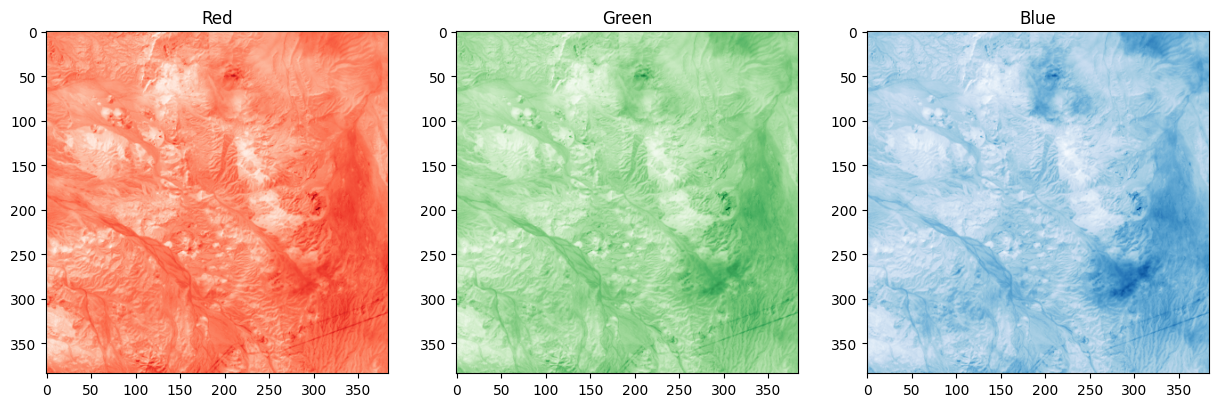

In [29]:
plt.figure(figsize=(15,15))

plt.subplot(131)
plt.title('Red')
plt.imshow(r, cmap='Reds')
plt.subplot(132)
plt.title('Green')
plt.imshow(g, cmap='Greens')
plt.subplot(133)
plt.title('Blue')
plt.imshow(b, cmap='Blues')

plt.show()

In [11]:
#Идентификация сцены, к которой относится этот фрагмент
ids95.SceneID == 'LC08_L1TP_006248_20160820_20170322_01_T1'
print('Latitud: ' + str(ids95.latitude[2]) + '; Longitud: ' + str(ids95.longitude[2]))

Latitud: 81.33221; Longitud: -20.56977


## Подготовка данных

### Разделить набор данных

Первый шаг-разделить набор данных на три части:

* **train**: используется для обучения модели, то есть расчета потерь и корректировки весов с помощью gradient descent. В этом случае он будет содержать 15000 изображений.
* **validation**: используется для оценки модели во время ее обучения, корректировки гиперпараметров и выбора наилучшей модели. В этом случае он будет содержать 5000 изображений, что составляет 25% от размера набора данных для обучения + проверки (обычно хорошей отправной точкой является набор с 80% данных для обучения и 20% для проверки)
* **test**: используется после завершения обучения в качестве параметра, чтобы понять, насколько хорошо обучена модель. То есть, закончив обучение, я передаю модели изображения, которые она никогда не видела, которые есть в этом наборе, и проверяю, насколько хорошо она может предсказать наличие облаков. В этом случае он будет содержать оставшиеся 6301 изображение.

In [12]:
def data_split(red_dir, train_size, val_size):
    '''
    Функция, которая загружает имена всех файлов с адреса в список,
    разбивает список на 3 части: размер train_size первый, размер val_size второй и общий размер -(train_size + val_size) третий.
    Наконец, он преобразует все адреса, которые были str, в объекты типа Path.
    Возвращает все 3 списка с адресами в формате Path.

    Параметры:
    -----------

    red_dir: улица. Адрес папки с красной полосой
    train_size: int. Размер обучающего набора данных
    val_size: int. Размер набора данных проверки

    Return:
    -------
    (train_list, val_list, test_list)

    '''

    if not (isinstance(red_dir, str)):
        raise AttributeError('red_dir must be a string')

    a = os.listdir(red_dir)
    b = np.split(a,[train_size,train_size+val_size,len(a)])
    train_files = b[0]
    val_files = b[1]
    test_files = b[2]

    train_list = []
    val_list = []
    test_list = []

    r_dir = Path(red_dir)

    for file_name in train_files:
        train_list.append(r_dir/file_name)

    for file_name in val_files:
        val_list.append(r_dir/file_name)

    for file_name in test_files:
        test_list.append(r_dir/file_name)

    return train_list, val_list, test_list

In [13]:
#начальный список файлов
total_list = data_split('data/95-cloud_training_only_additional_to38-cloud/train_red_additional_to38cloud', 15000, 5000)
len(total_list)

3

In [14]:
#длина каждого подсписка
print(len(total_list[0])) #training
print(len(total_list[1])) #validation
print(len(total_list[2])) #test

15000
5000
6301


In [15]:
# Объект в подсписке train, тот, который находится в позиции 3
total_list[0][3]

WindowsPath('data/95-cloud_training_only_additional_to38-cloud/train_red_additional_to38cloud/red_patch_100_5_by_12_LC08_L1TP_047017_20160920_20170221_01_T1.TIF')

### Требуется определение класса CloudDataset

Чтобы иметь возможность загружать изображения в набор данных и чтобы модель работала, для каждого исправления или обрезки надо:

- преобразовать это изображение TIF в массив numpy
- соедините его с патчами, которые соответствуют пространству остальных полос (сложите все 4 патча в стопку)
- преобразовать этот 4-мерный массив в тензор PyTorch

Решение состоит в том, чтобы создать класс, который наследуется от класса **torch.util.data.Набор данных**, подкласс. Это будет выполнять ту же функцию: загружать данные в набор данных и возвращать *входы*, в данном случае вырезы из изображений RGB, с соответствующими *целями*, в данном случае маской, соответствующей каждому фрагменту., но кроме того, мы должны добавить к нему другие функции, специально адаптированные к этому набору данных.

In [16]:
class CloudDataset(Dataset): #Подкласс класса Dataset

    def __init__(self, r_dir, g_dir, b_dir, nir_dir, gt_dir, file_list, pytorch=True):
        super().__init__() #создать экземпляр класса
        # Loop through the files in red folder and combine, into a dictionary, the other bands
        self.files = [self.combine_files(f, g_dir, b_dir, nir_dir, gt_dir) for f in file_list if not f.is_dir()]
        self.pytorch = pytorch

    def combine_files(self, r_file: Path, g_dir, b_dir,nir_dir, gt_dir):
        files = {'red': r_file,
                 'green': g_dir/r_file.name.replace('red', 'green'),
                 'blue': b_dir/r_file.name.replace('red', 'blue'),
                 'nir': nir_dir/r_file.name.replace('red', 'nir'),
                 'gt': gt_dir/r_file.name.replace('red', 'gt')}
        return files

    def __len__(self):
        return len(self.files)

    def open_as_array(self, idx, invert=False, include_nir=False):
        raw_rgb = np.stack([np.array(Image.open(self.files[idx]['red'])),
                            np.array(Image.open(self.files[idx]['green'])),
                            np.array(Image.open(self.files[idx]['blue'])),
                           ], axis=2)
        if include_nir:
            nir = np.expand_dims(np.array(Image.open(self.files[idx]['nir'])), 2)
            raw_rgb = np.concatenate([raw_rgb, nir], axis=2)
        if invert:
            raw_rgb = raw_rgb.transpose((2,0,1))
        return (raw_rgb / np.iinfo(raw_rgb.dtype).max)  # normalized


    def open_mask(self, idx, add_dims=False):
        raw_mask = np.array(Image.open(self.files[idx]['gt']))
        raw_mask = np.where(raw_mask==255, 1, 0)
        return np.expand_dims(raw_mask, 0) if add_dims else raw_mask

    def __getitem__(self, idx):
        x = torch.tensor(self.open_as_array(idx, invert=self.pytorch, include_nir=True), dtype=torch.float32)
        y = torch.tensor(self.open_mask(idx, add_dims=False), dtype=torch.torch.int64)
        return x, y

    def open_as_pil(self, idx):
        arr = 256*self.open_as_array(idx)
        return Image.fromarray(arr.astype(np.uint8), 'RGB')

    def __repr__(self):
        s = 'Dataset class with {} files'.format(self.__len__())
        return s

__Explicacion por partes:__

__class__ CloudDataset(Dataset): --> создает подкласс CloudDataset класса Dataset
>
    def __init__(self, r_dir, g_dir, b_dir, nir_dir, gt_dir, pytorch=True):
        super().__init__() #para instanciar la clase
        
Он определяет параметры, которые передаются классу, затем создает экземпляр класса. Параметры следующие:
1. r_dir: улица. Направление, в котором обрезки изображений находятся в красной видимой полосе.
2. g_dir: улица. Направление, в котором обрезки изображений находятся в зеленой видимой полосе.
3. b_dir: ул. Направление, в котором обрезки изображений находятся в синей видимой полосе.
4. nir_dir: улица. Направление, в котором находятся вырезки изображений в ближнем инфракрасном диапазоне.
5. gt_dir: улица. Адрес, где находятся вырезки изображений из масок.
6. file_list: список путей к файлам.
7. pytorch: Логическое значение. Активируйте библиотеку PyTorch.

Следующее выполняет итерацию по файлам в папке r_dir и объединяет каждое изображение в этом канале (красное) с таким же (пространственным) изображением, но в других каналах, и соответствующей маской.

     for file in r_dir.iterdir():
         if not file.is_dir():
             self.files = [self.combine_files(f, g_dir, b_dir, nir_dir, gt_dir)]
     #self.pytorch = pytorch NO SE QUE HACE
        

Функция __file. is_dir()__ Возвращает значение True, если путь указывает на каталог (папку); значение False, если он указывает на другой тип файла или путь не существует или не работает.

- Функция __combine_files__

         def combine_files(self, r_file: Path, g_dir, b_dir,nir_dir, gt_dir):
             files = {'red': r_file,
                 'green': g_dir/r_file.name.replace('red', 'green'),
                 'blue': b_dir/r_file.name.replace('red', 'blue'),
                 'nir': nir_dir/r_file.name.replace('red', 'nir'),
                 'gt': gt_dir/r_file.name.replace('red', 'gt')}
        return files        
Каждое изображение в открываемой вами папке Red Channel объединяется в словаре с таким же пространственным изображением, но в других каналах. Для каждого элемента _ключ_ - это имя канала, а _значение_-это адрес (тип пути) изображения. Вот почему для каналов, отличных от красных, например, для зеленой папки открывается тот же файл, но там, где написано red, меняется на green.
        
- Функция __len__

        def __len__(self):
            return len(self.files)
Возвращает количество элементов в наборе данных.

- Функция __open_as_array__

        def open_as_array(self, idx, invert=False, include_nir=False):
            raw_rgb = np.stack([np.array(Image.open(self.files[idx]['red'])),
                            np.array(Image.open(self.files[idx]['green'])),
                            np.array(Image.open(self.files[idx]['blue'])),
                           ], axis=2)
            if include_nir:
                nir = np.expand_dims(np.array(Image.open(self.files[idx]['nir'])), 2)
                raw_rgb = np.concatenate([raw_rgb, nir], axis=2)
            if invert:
                raw_rgb = raw_rgb.transpose((2,0,1))
        return (raw_rgb / np.iinfo(raw_rgb.dtype).max)   # normalize       
Открывает нормализованные изображения RGB в виде массивов Numpy. Кроме того, к массиву, содержащему ближний инфракрасный диапазон, можно добавить измерение (очевидно, если эта функция включена, невозможно отобразить изображение как RGB, например, с помощью plt.imshow).
параметр iinfo = Тип целочисленного типа данных, о котором требуется получить информацию.

- Функция * * open_as_pil**

        def open_as_pil(self, idx):
        arr = 256*self.open_as_array(idx)
        return Image.fromarray(arr.astype(np.uint8), 'RGB')
Открывайте изображения RGB как изображения PIL.

Ниже я использую этот класс:

In [17]:
#адрес родительской папки, содержащей все изображения
path_ppal = Path('data/95-cloud_training_only_additional_to38-cloud')

In [18]:
#Загрузка файлов обучающего набора в набор данных, это первый элемент в списке total_lista
train_dataset = CloudDataset(path_ppal/'train_red_additional_to38cloud',
                    path_ppal/'train_green_additional_to38cloud',
                    path_ppal/'train_blue_additional_to38cloud',
                    path_ppal/'train_nir_additional_to38cloud',
                    path_ppal/'train_gt_additional_to38cloud',
                    total_list[0])
len(train_dataset)

15000

In [19]:
#Загрузка файлов из проверочного набора в набор данных, это второй элемент в total_list_list
val_dataset = CloudDataset(path_ppal/'train_red_additional_to38cloud',
                    path_ppal/'train_green_additional_to38cloud',
                    path_ppal/'train_blue_additional_to38cloud',
                    path_ppal/'train_nir_additional_to38cloud',
                    path_ppal/'train_gt_additional_to38cloud',
                    total_list[1])
len(val_dataset)

5000

In [20]:
#Загрузка файлов тестового набора в набор данных, это третий элемент в списке total_lista
test_dataset = CloudDataset(path_ppal/'train_red_additional_to38cloud',
                    path_ppal/'train_green_additional_to38cloud',
                    path_ppal/'train_blue_additional_to38cloud',
                    path_ppal/'train_nir_additional_to38cloud',
                    path_ppal/'train_gt_additional_to38cloud',
                    total_list[2])
len(test_dataset)

6301

In [21]:
#Проверка размера объектов в наборах данных
x, y = train_dataset[0]
x.shape, y.shape

(torch.Size([4, 384, 384]), torch.Size([384, 384]))

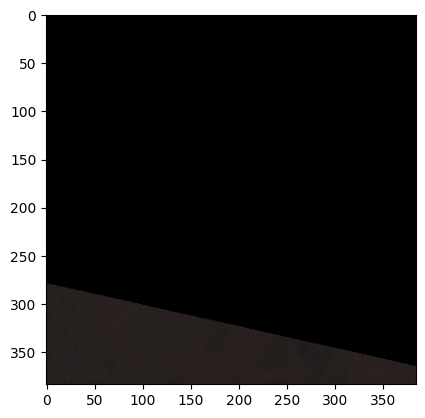

In [22]:
#Открытие файла как изображение PIL
plt.imshow(train_dataset.open_as_pil(13234))

np.float64(0.19107347219043258)

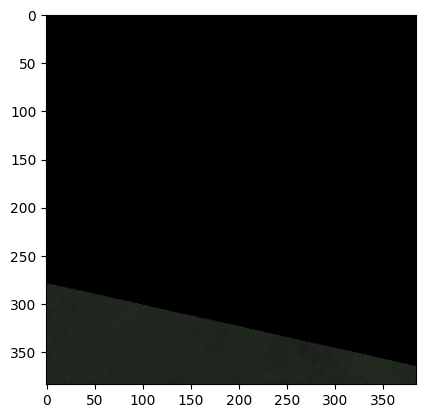

In [23]:
#Открытие того же файл как np. array
array = train_dataset.open_as_array(13234)
rgb = np.zeros([384,384,3])
rgb[:,:,0] = array[:,:,1]
rgb[:,:,1] = array[:,:,0]
rgb[:,:,2] = array[:,:,2]

plt.imshow(rgb)
rgb.max()

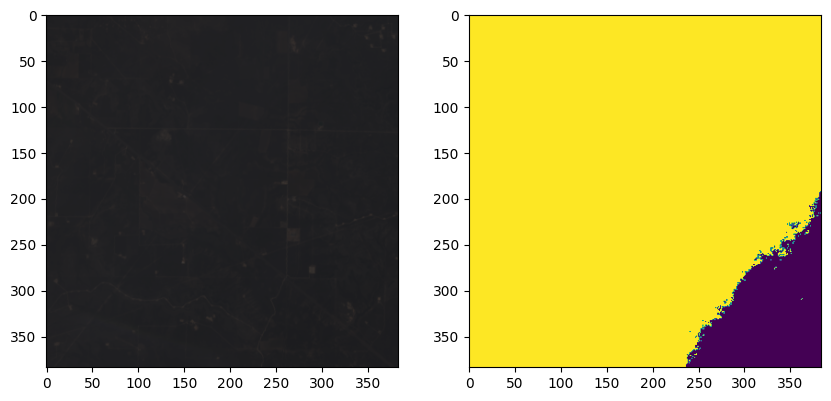

In [24]:
#Открытие файла как массив и его соответствующую маску
fig, ax = plt.subplots(1,2, figsize=(10,9))
ax[0].imshow(train_dataset.open_as_array(3570))
ax[1].imshow(train_dataset.open_mask(3570))

### Dataloaders
Создание загрузчика данных и определение размера пакета для пакетной загрузки набора данных.

In [25]:
batch_size = 16

In [26]:
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)

In [27]:
def show_batch(dl): 
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=4).permute(1, 2, 0), cmap='gray')

        #fig2, ax2 = plt.subplots(figsize=(8, 8))
        #ax2.set_xticks([]); ax2.set_yticks([])

        #ax2.imshow(make_grid(labels, nrow=4).permute(1, 2,0))

        break

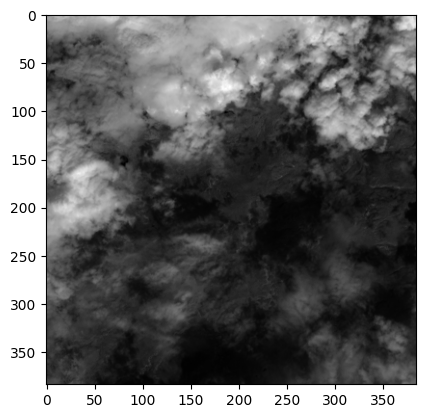

In [29]:
gt2_img = Image.open('data/95-cloud_training_only_additional_to38-cloud/train_nir_additional_to38cloud/nir_patch_100_5_by_12_LC08_L1TP_054019_20160820_20170221_01_T1.TIF')
plt.imshow(gt2_img, cmap='gray')